# Comparison models to test the CatBoost against other models
Predictions of Lymphocytes, tumorogenesis???

- 1.) ElasticNet
- 2.) Support Vector Regression
- 3.) Mixed linear modeling
- 4.) XGBoost
- 5.) DL model???

In [45]:
### Using monkey_env/ ###

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
import matplotlib.gridspec as gridspec
import math
import random

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost
from catboost import Pool

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

import warnings
warnings.filterwarnings("ignore")

print("Setup Complete")


Setup Complete


In [47]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [48]:
#Make a df for the blood analytic data
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    #date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
minbio_monkey_df.set_index(['ID'])
minbio_monkey_df['ID'] = minbio_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

minbio_monkey_df.columns
#minbio_monkey_df.tail()


Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [49]:
# Make a df of a single monkey's blood analytic data
single_minbio_df = minbio_monkey_df.copy()
single_minbio_df = single_minbio_df[single_minbio_df['ID'] == '2046']
single_minbio_df.set_index(['ID'])
#single_minbio_df.reset_index()
single_minbio_df.head()


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,2017-11-02,Yes,2014-04-09,2007-07-03,F,Clinical,1303.0,43.0,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,2017-12-13,Yes,2014-04-09,2007-07-03,F,Clinical,1344.0,44.0,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386
35,2046,Rhesus-Chinese,2018-01-02,Yes,2014-04-09,2007-07-03,F,Research,1364.0,45.0,...,39.9,6.0,0.3,0.3,2140,1596,240,12,12,309
36,2046,Rhesus-Chinese,2018-01-31,Yes,2014-04-09,2007-07-03,F,Research,1393.0,46.0,...,46.8,5.6,0.5,0.0,2025,2012,241,22,0,275
37,2046,Rhesus-Chinese,2018-04-05,Yes,2014-04-09,2007-07-03,F,Research,1457.0,48.0,...,22.8,5.8,0.1,0.1,6123,1961,499,9,9,325


# ElasticNet
- All inputs have to be numeric
- Can't handle NaN
- It looks like it works but I think something is up

In [50]:
# evaluate an elastic net model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet

In [51]:
minbio_monkey_df.head(2)

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,2017-12-20,No,NaT,2007-05-14,F,Clinical,NaN,NaN,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,2018-01-29,No,NaT,2007-05-14,F,Research,NaN,NaN,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


In [52]:
#count control monkeys
print('Non-Irradiated Samples:{}'.format(minbio_monkey_df['IRRAD'].value_counts()['No']))
 
# Count the irradiated monkeys
print('Irradiated Samples:{}'.format(minbio_monkey_df['IRRAD'].value_counts()['Yes']))

#Count Males
print('Males:{}'.format(minbio_monkey_df['SEX'].value_counts()['M']))
 
# Count females
print('Females:{}'.format(minbio_monkey_df['SEX'].value_counts()['F']))


Non-Irradiated Samples:970
Irradiated Samples:3582
Males:3608
Females:944


In [53]:
#make a parent df
minbio_monkey_df.copy()
elnet_df = minbio_monkey_df

#Exclude datetime and catagorical feautres
elnet_df=elnet_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
elnet_df['SEX'] = elnet_df['SEX'].map({'M':1, 'F': 0})
elnet_df['IRRAD'] = elnet_df['IRRAD'].map({'Yes':1, 'No': 0})


# Take care of NaN
elnet_df['DOSE_(Gy)'] = elnet_df['DOSE_(Gy)'].fillna(0)
elnet_df['DAYS_SINCE_IRRAD'] = elnet_df['DAYS_SINCE_IRRAD'].fillna(0)
elnet_df['MONTHS_SINCE_IRRAD'] = elnet_df['MONTHS_SINCE_IRRAD'].fillna(0)
elnet_df['MONTHS AT IRRAD'] = elnet_df['MONTHS AT IRRAD'].fillna(0)

elnet_df.head(5)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,0,0,0.0,0.0,0.0,0.0,10.6,10.9,5.05,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,0,0,0.0,0.0,0.0,0.0,10.7,8.8,4.59,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334
2,2061,0,0,0.0,0.0,0.0,0.0,10.9,17.5,4.74,...,8.5,3.4,0.1,0.1,15383,1488,595,18,18,321
3,2061,0,0,0.0,0.0,0.0,0.0,11.3,21.1,4.76,...,5.5,2.7,0.1,0.0,19349,1161,570,21,0,310
4,2061,0,0,0.0,0.0,0.0,0.0,11.6,11.5,4.53,...,14.5,6.6,0.1,0.0,9062,1668,759,12,0,486


In [54]:
#count control monkeys
print('Non-Irradiated Samples:{}'.format(elnet_df['IRRAD'].value_counts()[0]))
 
# Count the irradiated monkeys
print('Irradiated Samples:{}'.format(elnet_df['IRRAD'].value_counts()[1]))

#Count Males
print('Males:{}'.format(elnet_df['SEX'].value_counts()[1]))
 
# Count females
print('Females:{}'.format(elnet_df['SEX'].value_counts()[0]))

Non-Irradiated Samples:970
Irradiated Samples:3582
Males:3608
Females:944


## With the NaN converted to 0

In [55]:
y=elnet_df['LYMPHOCYTES_(%)']
X=elnet_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

data= train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_validation, y_train, y_validation= data

train_pool = Pool(
    data = X_train,
    label = y_train
)


validation_pool = Pool(
    data = X_validation,
    label = y_validation,
)


In [56]:

# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# fit model
model.fit(X_train, y_train)

ElasticNet()

Plot Title: t


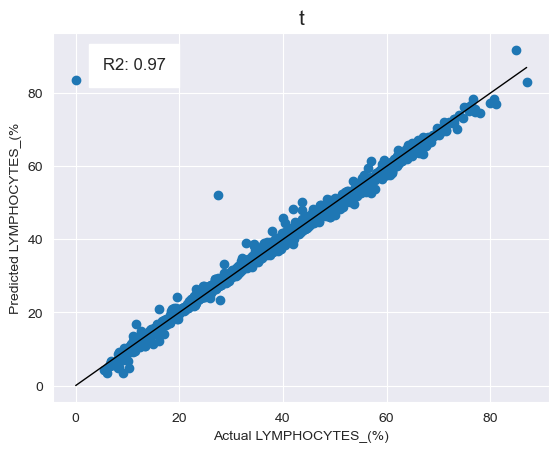

MSE: 6.833576316708059


In [57]:
# make a prediction
a = model.predict(X_validation)
a_df = pd.DataFrame(a)


### Plotting ###
# Plot the predictions
fig, ax = plt.subplots()
ax.scatter(y_validation, a_df)

ax.plot([y.min(), y.max()], [y.min(), y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual LYMPHOCYTES_(%)')
ax.set_ylabel('Predicted LYMPHOCYTES_(%')

#Title of the plot
plot_title = input("Plot Title:")
#show_iters = model.get_param('iterations')  
ax.set_title(plot_title #+ "\nIterations: {}".format(str(show_iters))
             ,fontsize=15
)

#cordinates for the R2 value box
xmin, xmax, ymin, ymax = plt.axis()
yrange = ymax-ymin
xrange = xmax-xmin


#Plotting the R2 score and MSE
ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
            xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
            fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)


plt.show() 



## Without NaN converted to 0

In [58]:
#make a parent df
minbio_monkey_df.copy()
no_df = minbio_monkey_df

#Exclude datetime and catagorical feautres
no_df=no_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE','DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
no_df['SEX'] = no_df['SEX'].map({'M':1, 'F': 0})
no_df['IRRAD'] = no_df['IRRAD'].map({'Yes':1, 'No': 0})
no_df['DOSE_(Gy)'] = no_df['DOSE_(Gy)'].fillna(0)

no_df.head(2)

,ID,IRRAD,SEX,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),Hemaglobin_(HGB_g/dL),Hemocrit_(HCT_%),Mean_corpuscular_volume_(MCV_fL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,0,0,0.0,10.6,10.9,5.05,12.0,35.7,70.69,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,0,0,0.0,10.7,8.8,4.59,10.5,33.3,72.55,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


In [59]:
y=no_df['LYMPHOCYTES_(%)']
X=no_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

data= train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_validation, y_train, y_validation= data

train_pool = Pool(
    data = X_train,
    label = y_train
)


validation_pool = Pool(
    data = X_validation,
    label = y_validation,
)

In [60]:
# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# fit model
model.fit(X_train, y_train)

ElasticNet()

Plot Title: t


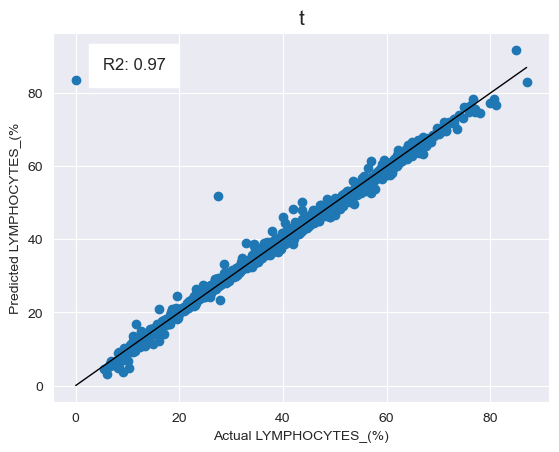

MSE: 6.833730681830678


In [62]:
# make a prediction
a = model.predict(X_validation)
a_df = pd.DataFrame(a)


### Plotting ###
# Plot the predictions
fig, ax = plt.subplots()
ax.scatter(y_validation, a_df)

ax.plot([y.min(), y.max()], [y.min(), y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual LYMPHOCYTES_(%)')
ax.set_ylabel('Predicted LYMPHOCYTES_(%')

#Title of the plot
plot_title = input("Plot Title:")
#show_iters = model.get_param('iterations')  
ax.set_title(plot_title #+ "\nIterations: {}".format(str(show_iters))
             ,fontsize=15
)

#cordinates for the R2 value box
xmin, xmax, ymin, ymax = plt.axis()
yrange = ymax-ymin
xrange = xmax-xmin


#Plotting the R2 score and MSE
ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
            xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
            fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)


plt.show() 

## Predicting single monkey biomarkers w/multi monkey data

In [69]:
single_df=single_minbio_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE','DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
single_df['SEX'] = single_df['SEX'].map({'M':1, 'F': 0})
single_df['IRRAD'] = single_df['IRRAD'].map({'Yes':1, 'No': 0})
single_df['DOSE_(Gy)'] = single_df['DOSE_(Gy)'].fillna(0)

single_df.head(2)

,ID,IRRAD,SEX,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),Hemaglobin_(HGB_g/dL),Hemocrit_(HCT_%),Mean_corpuscular_volume_(MCV_fL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,1,0,1.14,10.3,3.8,6.08,14.2,41.6,68.42,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,1,0,1.14,10.4,7.0,5.38,12.2,36.2,67.29,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386


In [70]:
no_df.head(2)

,ID,IRRAD,SEX,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),Hemaglobin_(HGB_g/dL),Hemocrit_(HCT_%),Mean_corpuscular_volume_(MCV_fL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,0,0,0.0,10.6,10.9,5.05,12.0,35.7,70.69,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,0,0,0.0,10.7,8.8,4.59,10.5,33.3,72.55,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


In [71]:
# Split the dfs

# multi monkey data split
mul_y=no_df['LYMPHOCYTES_(%)']
mul_X=no_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

mul_data= train_test_split(mul_X, mul_y, test_size=0.3, random_state=0)
mul_X_train, mul_X_validation, mul_y_train, mul_y_validation= mul_data

mul_train_pool = Pool(
    data = mul_X_train,
    label = mul_y_train
)


mul_validation_pool = Pool(
    data = mul_X_validation,
    label = mul_y_validation,
)


# single monkey data split
sin_y=single_df['LYMPHOCYTES_(%)']
sin_X=single_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

sin_data= train_test_split(sin_X, sin_y, test_size=0.3, random_state=0)
sin_X_train, sin_X_validation, sin_y_train, sin_y_validation= sin_data

sin_train_pool = Pool(
    data = sin_X_train,
    label = sin_y_train
)


sin_validation_pool = Pool(
    data = sin_X_validation,
    label = sin_y_validation,
)





In [72]:
# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# fit model
model.fit(mul_X_train, mul_y_train)

ElasticNet()

Plot Title: t


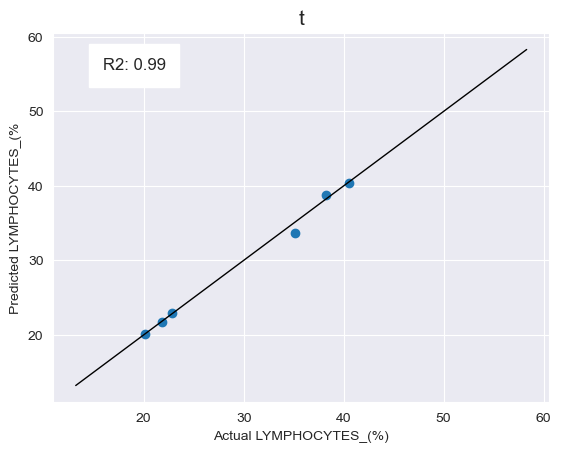

MSE: 0.398251124912186


In [74]:
# make a prediction
a = model.predict(sin_X_validation)
a_df = pd.DataFrame(a)


### Plotting ###
# Plot the predictions
fig, ax = plt.subplots()
ax.scatter(sin_y_validation, a_df)

ax.plot([sin_y.min(), sin_y.max()], [sin_y.min(), sin_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual LYMPHOCYTES_(%)')
ax.set_ylabel('Predicted LYMPHOCYTES_(%')

#Title of the plot
plot_title = input("Plot Title:")
#show_iters = model.get_param('iterations')  
ax.set_title(plot_title #+ "\nIterations: {}".format(str(show_iters))
             ,fontsize=15
)

#cordinates for the R2 value box
xmin, xmax, ymin, ymax = plt.axis()
yrange = ymax-ymin
xrange = xmax-xmin


#Plotting the R2 score and MSE
ax.annotate("R2: {}".format(str(r2_score(sin_y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(sin_y_validation, a_df).round(2))),
            xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
            fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)


plt.show() 


# XGBoost
- No catagorical
- Needs a lot of tuning

In [75]:
import xgboost as xgb
from xgboost import XGBRegressor

In [76]:
#make a parent df
minbio_monkey_df.copy()
xg_df = minbio_monkey_df

#Exclude datetime and catagorical feautres
xg_df=xg_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
xg_df['SEX'] = xg_df['SEX'].map({'M':1, 'F': 0})
xg_df['IRRAD'] = xg_df['IRRAD'].map({'Yes':1, 'No': 0})


# Take care of NaN
xg_df['DOSE_(Gy)'] = xg_df['DOSE_(Gy)'].fillna(0)

In [77]:
y=no_df['LYMPHOCYTES_(%)']
X=no_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

X_train, X_validation, y_train, y_validation = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)

model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
model.fit(X_train, y_train)
  
# Predict the model
a = model.predict(X_validation)
a_df = pd.DataFrame(a)

Plot Title: t


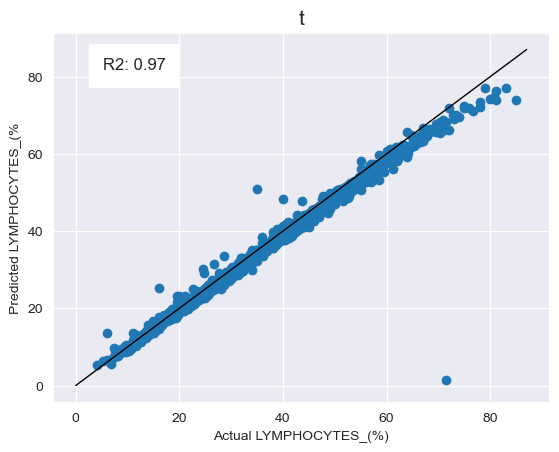

MSE: 6.476128731786306


In [79]:
# Plot the predictions
fig, ax = plt.subplots()
ax.scatter(y_validation, a_df)

ax.plot([y.min(), y.max()], [y.min(), y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual LYMPHOCYTES_(%)')
ax.set_ylabel('Predicted LYMPHOCYTES_(%')

#Title of the plot
plot_title = input("Plot Title:")
#show_iters = model.get_param('iterations')  
ax.set_title(plot_title #+ "\nIterations: {}".format(str(show_iters))
             ,fontsize=15
)

#cordinates for the R2 value box
xmin, xmax, ymin, ymax = plt.axis()
yrange = ymax-ymin
xrange = xmax-xmin


#Plotting the R2 score and MSE
ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
            xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
            fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)


plt.show()

## Predicting Single monkey biomarkers w/ multi monkey data`

In [80]:
#make a parent df
minbio_monkey_df.copy()
mul_xg_df = minbio_monkey_df

#Exclude datetime and catagorical feautres
mul_xg_df=mul_xg_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
mul_xg_df['SEX'] = mul_xg_df['SEX'].map({'M':1, 'F': 0})
mul_xg_df['IRRAD'] = mul_xg_df['IRRAD'].map({'Yes':1, 'No': 0})


# Take care of NaN
mul_xg_df['DOSE_(Gy)'] = mul_xg_df['DOSE_(Gy)'].fillna(0)

In [81]:
single_minbio_df.copy()
sin_xg_df = single_minbio_df

#Exclude datetime and catagorical feautres
sin_xg_df=sin_xg_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
sin_xg_df['SEX'] = sin_xg_df['SEX'].map({'M':1, 'F': 0})
sin_xg_df['IRRAD'] = sin_xg_df['IRRAD'].map({'Yes':1, 'No': 0})


# Take care of NaN
sin_xg_df['DOSE_(Gy)'] = sin_xg_df['DOSE_(Gy)'].fillna(0)


In [82]:
sin_y=sin_xg_df['LYMPHOCYTES_(%)']
sin_X=sin_xg_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

sin_X_train, sin_X_validation, sin_y_train, sin_y_validation = train_test_split(sin_X, sin_y,
                      test_size = 0.3, random_state = 123)

mul_y=mul_xg_df['LYMPHOCYTES_(%)']
mul_X=mul_xg_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

mul_X_train, mul_X_validation, mul_y_train, mul_y_validation = train_test_split(mul_X, mul_y,
                      test_size = 0.3, random_state = 123)




model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
model.fit(mul_X_train, mul_y_train)
  
# Predict the model
a = model.predict(sin_X_validation)
a_df = pd.DataFrame(a)

Plot Title: t


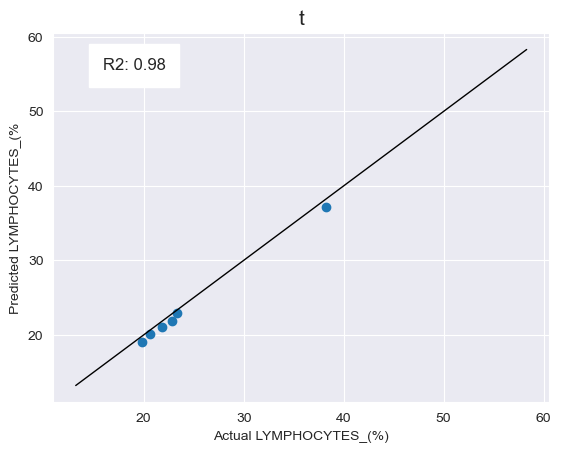

MSE: 0.6134436379267084


In [83]:
# Plot the predictions
fig, ax = plt.subplots()
ax.scatter(sin_y_validation, a_df)

ax.plot([sin_y.min(), sin_y.max()], [sin_y.min(), sin_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual LYMPHOCYTES_(%)')
ax.set_ylabel('Predicted LYMPHOCYTES_(%')

#Title of the plot
plot_title = input("Plot Title:")
#show_iters = model.get_param('iterations')  
ax.set_title(plot_title #+ "\nIterations: {}".format(str(show_iters))
             ,fontsize=15
)

#cordinates for the R2 value box
xmin, xmax, ymin, ymax = plt.axis()
yrange = ymax-ymin
xrange = xmax-xmin


    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(sin_y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(sin_y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    

plt.show() 


# DL model - JAX
Jax: https://github.com/google/jax

- Jax uses transformers 
https://theaisummer.com/jax-transformer/

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html

pytorch transformer: https://github.com/tunz/transformer-pytorch/blob/e7266679f0b32fd99135ea617213f986ceede056/model/transformer.py#L201


In [36]:
import jax
import jax.numpy as jnp
import haiku as hk
import numpy as np

In [43]:
class SelfAttention(hk.MultiHeadAttention):
    """Self attention with a causal mask applied."""

    def __call__(
            self,
            query: jnp.ndarray,
            key: Optional[jnp.ndarray] = None,
            value: Optional[jnp.ndarray] = None,
            mask: Optional[jnp.ndarray] = None,
    ) -> jnp.ndarray:
        key = key if key is not None else query
        value = value if value is not None else query

        seq_len = query.shape[1]
        causal_mask = np.tril(np.ones((seq_len, seq_len)))
        mask = mask * causal_mask if mask is not None else causal_mask

        return super().__call__(query, key, value, mask)

NameError: name 'Optional' is not defined

In [42]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import utils

# pylint: disable=arguments-differ


def initialize_weight(x):
    nn.init.xavier_uniform_(x.weight)
    if x.bias is not None:
        nn.init.constant_(x.bias, 0)


class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate):
        super(FeedForwardNetwork, self).__init__()

        self.layer1 = nn.Linear(hidden_size, filter_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(filter_size, hidden_size)

        initialize_weight(self.layer1)
        initialize_weight(self.layer2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, dropout_rate, head_size=8):
        super(MultiHeadAttention, self).__init__()

        self.head_size = head_size

        self.att_size = att_size = hidden_size // head_size
        self.scale = att_size ** -0.5

        self.linear_q = nn.Linear(hidden_size, head_size * att_size, bias=False)
        self.linear_k = nn.Linear(hidden_size, head_size * att_size, bias=False)
        self.linear_v = nn.Linear(hidden_size, head_size * att_size, bias=False)
        initialize_weight(self.linear_q)
        initialize_weight(self.linear_k)
        initialize_weight(self.linear_v)

        self.att_dropout = nn.Dropout(dropout_rate)

        self.output_layer = nn.Linear(head_size * att_size, hidden_size,
                                      bias=False)
        initialize_weight(self.output_layer)

    def forward(self, q, k, v, mask, cache=None):
        orig_q_size = q.size()

        d_k = self.att_size
        d_v = self.att_size
        batch_size = q.size(0)

        # head_i = Attention(Q(W^Q)_i, K(W^K)_i, V(W^V)_i)
        q = self.linear_q(q).view(batch_size, -1, self.head_size, d_k)
        if cache is not None and 'encdec_k' in cache:
            k, v = cache['encdec_k'], cache['encdec_v']
        else:
            k = self.linear_k(k).view(batch_size, -1, self.head_size, d_k)
            v = self.linear_v(v).view(batch_size, -1, self.head_size, d_v)

            if cache is not None:
                cache['encdec_k'], cache['encdec_v'] = k, v

        q = q.transpose(1, 2)                  # [b, h, q_len, d_k]
        v = v.transpose(1, 2)                  # [b, h, v_len, d_v]
        k = k.transpose(1, 2).transpose(2, 3)  # [b, h, d_k, k_len]

        # Scaled Dot-Product Attention.
        # Attention(Q, K, V) = softmax((QK^T)/sqrt(d_k))V
        q.mul_(self.scale)
        x = torch.matmul(q, k)  # [b, h, q_len, k_len]
        x.masked_fill_(mask.unsqueeze(1), -1e9)
        x = torch.softmax(x, dim=3)
        x = self.att_dropout(x)
        x = x.matmul(v)  # [b, h, q_len, attn]

        x = x.transpose(1, 2).contiguous()  # [b, q_len, h, attn]
        x = x.view(batch_size, -1, self.head_size * d_v)

        x = self.output_layer(x)

        assert x.size() == orig_q_size
        return x


class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate):
        super(EncoderLayer, self).__init__()

        self.self_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.self_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.ffn = FeedForwardNetwork(hidden_size, filter_size, dropout_rate)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):  # pylint: disable=arguments-differ
        y = self.self_attention_norm(x)
        y = self.self_attention(y, y, y, mask)
        y = self.self_attention_dropout(y)
        x = x + y

        y = self.ffn_norm(x)
        y = self.ffn(y)
        y = self.ffn_dropout(y)
        x = x + y
        return x


class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate):
        super(DecoderLayer, self).__init__()

        self.self_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.self_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

        self.enc_dec_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.enc_dec_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.enc_dec_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.ffn = FeedForwardNetwork(hidden_size, filter_size, dropout_rate)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, enc_output, self_mask, i_mask, cache):
        y = self.self_attention_norm(x)
        y = self.self_attention(y, y, y, self_mask)
        y = self.self_attention_dropout(y)
        x = x + y

        if enc_output is not None:
            y = self.enc_dec_attention_norm(x)
            y = self.enc_dec_attention(y, enc_output, enc_output, i_mask,
                                       cache)
            y = self.enc_dec_attention_dropout(y)
            x = x + y

        y = self.ffn_norm(x)
        y = self.ffn(y)
        y = self.ffn_dropout(y)
        x = x + y
        return x


class Encoder(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate, n_layers):
        super(Encoder, self).__init__()

        encoders = [EncoderLayer(hidden_size, filter_size, dropout_rate)
                    for _ in range(n_layers)]
        self.layers = nn.ModuleList(encoders)

        self.last_norm = nn.LayerNorm(hidden_size, eps=1e-6)

    def forward(self, inputs, mask):
        encoder_output = inputs
        for enc_layer in self.layers:
            encoder_output = enc_layer(encoder_output, mask)
        return self.last_norm(encoder_output)


class Decoder(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate, n_layers):
        super(Decoder, self).__init__()

        decoders = [DecoderLayer(hidden_size, filter_size, dropout_rate)
                    for _ in range(n_layers)]
        self.layers = nn.ModuleList(decoders)

        self.last_norm = nn.LayerNorm(hidden_size, eps=1e-6)

    def forward(self, targets, enc_output, i_mask, t_self_mask, cache):
        decoder_output = targets
        for i, dec_layer in enumerate(self.layers):
            layer_cache = None
            if cache is not None:
                if i not in cache:
                    cache[i] = {}
                layer_cache = cache[i]
            decoder_output = dec_layer(decoder_output, enc_output,
                                       t_self_mask, i_mask, layer_cache)
        return self.last_norm(decoder_output)


class Transformer(nn.Module):
    def __init__(self, i_vocab_size, t_vocab_size,
                 n_layers=6,
                 hidden_size=512,
                 filter_size=2048,
                 dropout_rate=0.1,
                 share_target_embedding=True,
                 has_inputs=True,
                 src_pad_idx=None,
                 trg_pad_idx=None):
        super(Transformer, self).__init__()

        self.hidden_size = hidden_size
        self.emb_scale = hidden_size ** 0.5
        self.has_inputs = has_inputs
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        self.t_vocab_embedding = nn.Embedding(t_vocab_size, hidden_size)
        nn.init.normal_(self.t_vocab_embedding.weight, mean=0,
                        std=hidden_size**-0.5)
        self.t_emb_dropout = nn.Dropout(dropout_rate)
        self.decoder = Decoder(hidden_size, filter_size,
                               dropout_rate, n_layers)

        if has_inputs:
            if not share_target_embedding:
                self.i_vocab_embedding = nn.Embedding(i_vocab_size,
                                                      hidden_size)
                nn.init.normal_(self.i_vocab_embedding.weight, mean=0,
                                std=hidden_size**-0.5)
            else:
                self.i_vocab_embedding = self.t_vocab_embedding

            self.i_emb_dropout = nn.Dropout(dropout_rate)

            self.encoder = Encoder(hidden_size, filter_size,
                                   dropout_rate, n_layers)

        # For positional encoding
        num_timescales = self.hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0
        log_timescale_increment = (
            math.log(float(max_timescale) / float(min_timescale)) /
            max(num_timescales - 1, 1))
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)

    def forward(self, inputs, targets):
        enc_output, i_mask = None, None
        if self.has_inputs:
            i_mask = utils.create_pad_mask(inputs, self.src_pad_idx)
            enc_output = self.encode(inputs, i_mask)

        t_mask = utils.create_pad_mask(targets, self.trg_pad_idx)
        target_size = targets.size()[1]
        t_self_mask = utils.create_trg_self_mask(target_size,
                                                 device=targets.device)
        return self.decode(targets, enc_output, i_mask, t_self_mask, t_mask)

    def encode(self, inputs, i_mask):
        # Input embedding
        input_embedded = self.i_vocab_embedding(inputs)
        input_embedded.masked_fill_(i_mask.squeeze(1).unsqueeze(-1), 0)
        input_embedded *= self.emb_scale
        input_embedded += self.get_position_encoding(inputs)
        input_embedded = self.i_emb_dropout(input_embedded)

        return self.encoder(input_embedded, i_mask)

    def decode(self, targets, enc_output, i_mask, t_self_mask, t_mask,
               cache=None):
        # target embedding
        target_embedded = self.t_vocab_embedding(targets)
        target_embedded.masked_fill_(t_mask.squeeze(1).unsqueeze(-1), 0)

        # Shifting
        target_embedded = target_embedded[:, :-1]
        target_embedded = F.pad(target_embedded, (0, 0, 1, 0))

        target_embedded *= self.emb_scale
        target_embedded += self.get_position_encoding(targets)
        target_embedded = self.t_emb_dropout(target_embedded)

        # decoder
        decoder_output = self.decoder(target_embedded, enc_output, i_mask,
                                      t_self_mask, cache)
        # linear
        output = torch.matmul(decoder_output,
                              self.t_vocab_embedding.weight.transpose(0, 1))

        return output

    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32,
                                device=x.device)
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)],
                           dim=1)
        signal = F.pad(signal, (0, 0, 0, self.hidden_size % 2))
        signal = signal.view(1, max_length, self.hidden_size)
        return signal


NameError: name '_C' is not defined